### Informative score and similarity analysis

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from scipy.stats import spearmanr as scor
from scipy.stats import pearsonr as pcor
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
def plot_correaltions_all(dname1,name1,abs_type= '_abs',rnd_fil='_filtered',bname='progeny',sim_type='jaccard'):
    sns.set_palette('GnBu',6)
    dnames=list(set(['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP'])-set([dname1]))
    dnames.sort(reverse=True)
    activities=pd.Series()
    similiarities=pd.Series()
    sizes=pd.Series()
    dset_names=[]
    for dname in dnames:
        activity=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname,rnd_fil,abs_type),
                         sep=',',header=0,index_col=0).abs().max(1)
        if dname1<dname:
            fname=dname1+rnd_fil+'_'+dname+rnd_fil+'_'+sim_type+'.csv'
        else:
            fname=dname+rnd_fil+'_'+dname1+rnd_fil+'_'+sim_type+'.csv'
        similarity=pd.read_csv('../results/similarity/'+fname,sep=',',header=0,index_col=0)
        size=pd.read_csv('../results/genesets/single/csvs/%s%s.csv' % (dname,rnd_fil),sep=',',
                         header=0,index_col=0)
        size=size['Set'].value_counts()
        if dname1<dname:
            similarity=similarity.max(0)
        else:
            similarity=similarity.max(1)
        sets=list(set(activity.index)&set(similarity.index)) 
        activities=pd.concat([activities,activity[sets]])   
        similiarities=pd.concat([similiarities,similarity[sets]])
        sizes=pd.concat([sizes,size[sets]])
        if 'dorothea' not in dname:
            dset_names+=[dname]*len(sets)
        elif dname == 'BEST_dorothea_AB':
            dset_names += ['High confidence\nDoRothEA']*len(sets)
        else:
            dset_names += ['Low confidence\nDoRothEA']*len(sets)
    plt.figure(figsize=(4,3),dpi=300)
    sns.scatterplot(similiarities,activities,hue=dset_names, alpha=0.7)
    if sim_type=='jaccard':
        sim_label='Jaccard index'
    else:
        sim_label='Overlap coefficient'
    plt.xlabel('Similarity to '+name1+'\n('+sim_label+')',size=13)
    plt.ylabel('Informative score',size=13)
    plt.legend(fontsize=7)
    plt.tight_layout()
    print(scor(activities,similiarities))

SpearmanrResult(correlation=0.23584305188949806, pvalue=3.7189093459986374e-65)


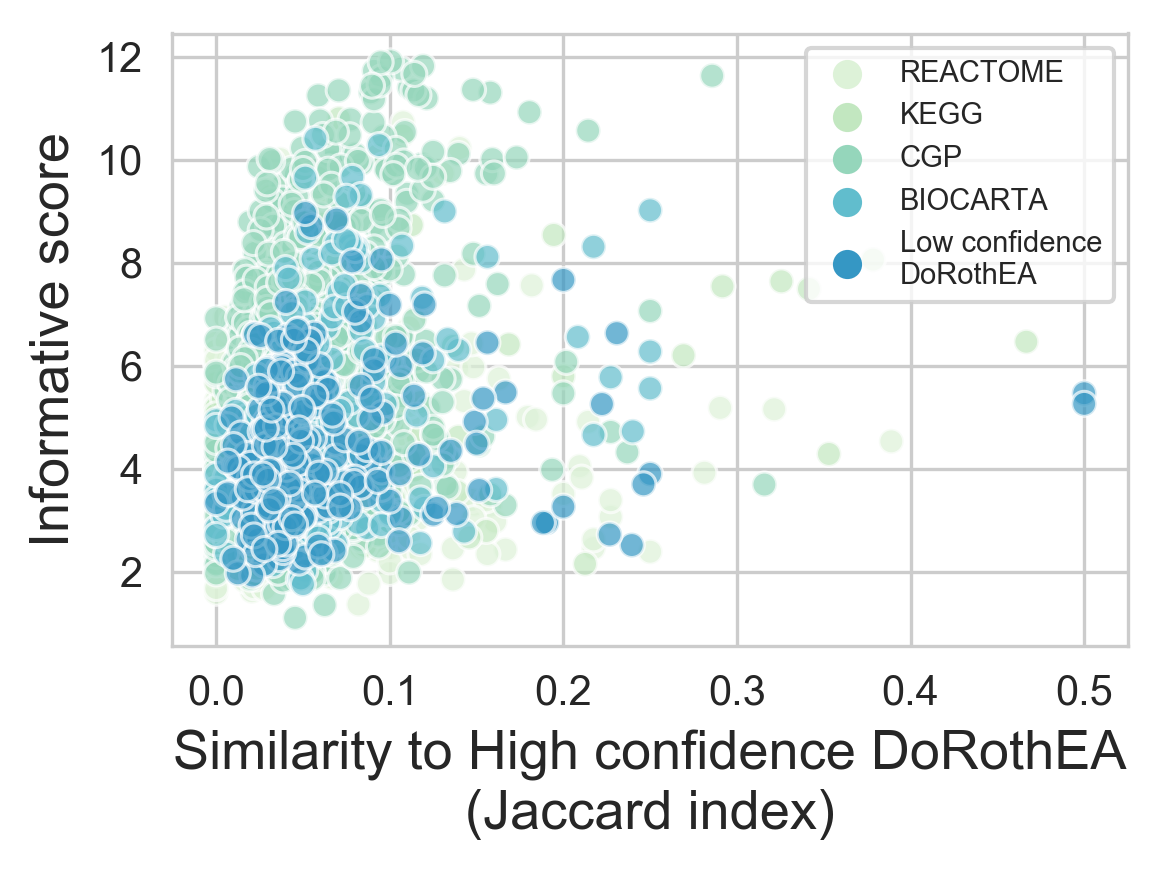

In [3]:
plot_correaltions_all('BEST_dorothea_AB','High confidence DoRothEA','_abs','_filtered','progeny','jaccard')
plt.savefig('../figures/raw/Fig4A.pdf')

SpearmanrResult(correlation=0.030150997717194566, pvalue=0.03481435101401067)


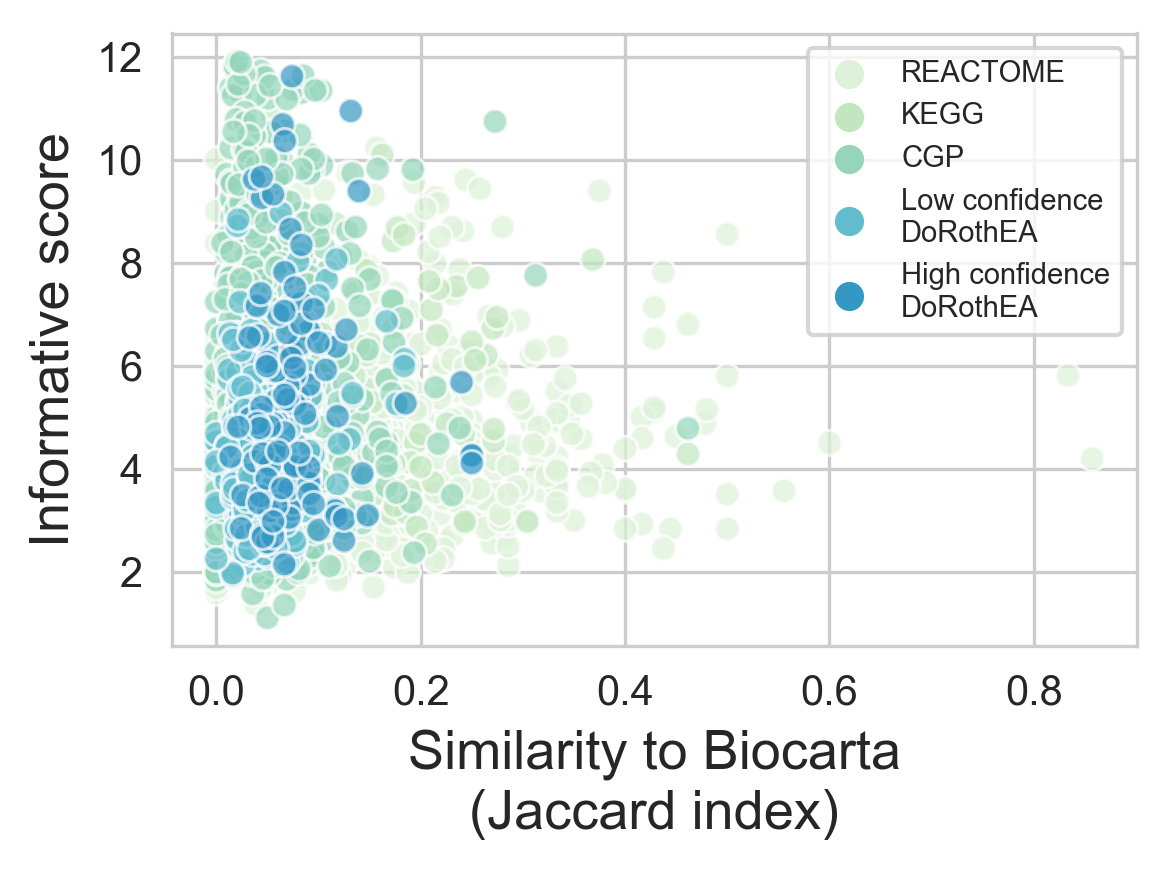

In [4]:
plot_correaltions_all('BIOCARTA','Biocarta','_abs','_filtered','progeny','jaccard')
plt.savefig('../figures/raw/Fig4B.pdf')

In [5]:
def get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_filtered',bname='progeny',sim_type='jaccard',
                                 visualise = False):
    dsets={'BEST_dorothea_AB':'High confidence\nDoRothEA',
           'BEST_dorothea_CD':'Low confidence\nDoRothEA',
           'KEGG':'KEGG',
           'BIOCARTA':'BIOCARTA',
           'REACTOME':'REACTOME',
           'CGP':'CGP'}
    dset_names1 = []
    dset_names2 = []
    activities = []
    similiarities = []
    sizes = []
    for dname1 in dsets:
        dnames=list(set(['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP'])-set([dname1]))
        dnames.sort(reverse=True)
        for dname in dnames:
            activity=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,dname,rnd_fil,abs_type),
                             sep=',',header=0,index_col=0).abs().max(1)
            if dname1<dname:
                fname=dname1+rnd_fil+'_'+dname+rnd_fil+'_'+sim_type+'.csv'
            else:
                fname=dname+rnd_fil+'_'+dname1+rnd_fil+'_'+sim_type+'.csv'
            similarity=pd.read_csv('../results/similarity/'+fname,sep=',',header=0,index_col=0)
            size=pd.read_csv('../results/genesets/single/csvs/%s%s.csv' % (dname,rnd_fil),sep=',',
                             header=0,index_col=0)
            size=size['Set'].value_counts()
            if dname1<dname:
                similarity=similarity.max(0)
            else:
                similarity=similarity.max(1)
            sets=list(set(activity.index)&set(similarity.index)) 
            activities += list(activity[sets])
            similiarities += list(similarity[sets])
            sizes += list(size[sets])
            dset_names1 += [dname1] * len(sets)
            dset_names2 += [dname] * len(sets)
    results = pd.DataFrame(index = range(len(activities)))
    results['Activity'] = activities; results['Similarity'] = similiarities
    results['Size'] = sizes; results['Dataset1'] = dset_names1; results['Dataset2'] = dset_names2
    stat_results = pd.DataFrame(columns = ['Database', 'r_spearman', 'p_spearman', 'r_part', 'p_part'] )
    i = 0
    for dset in results['Dataset1'].unique():
            fil = results['Dataset1'] == dset
            model1 = smf.ols('Activity ~ Size', results[fil]).fit()
            model2 = smf.ols('Similarity ~ Size', results[fil]).fit()
            stat_results.loc[i] = [dset] + list(scor(results['Activity'][fil], results['Similarity'][fil])) +\
                list(pcor(model1.resid, model2.resid))
            i += 1
    stat_results.index = stat_results['Database']
    stat_results = stat_results.loc[['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP']]
    stat_results['Database'] = stat_results['Database'].map(dsets)
    stat_results['Random'] = rnd_fil
    stat_results['Benchmark'] = bname
    stat_results['Abs'] = abs_type
    stat_results['Sim'] = sim_type
    if visualise:
        sns.set_palette('GnBu',2)
        plt.figure(figsize=(4,4),dpi=300)
        plt.stem(np.arange(0.5,6.5,1), stat_results['r_part'])
        plt.xticks(np.arange(0.5,6.5,1), stat_results['Database'], rotation=45)
        plt.ylim(-0.1,0.3)
        plt.xlabel('Similarity to gene set database', size=13)
        plt.ylabel('Partial correlation between\nsimilarity and infromative score', size=13)
        plt.tight_layout()
    return stat_results

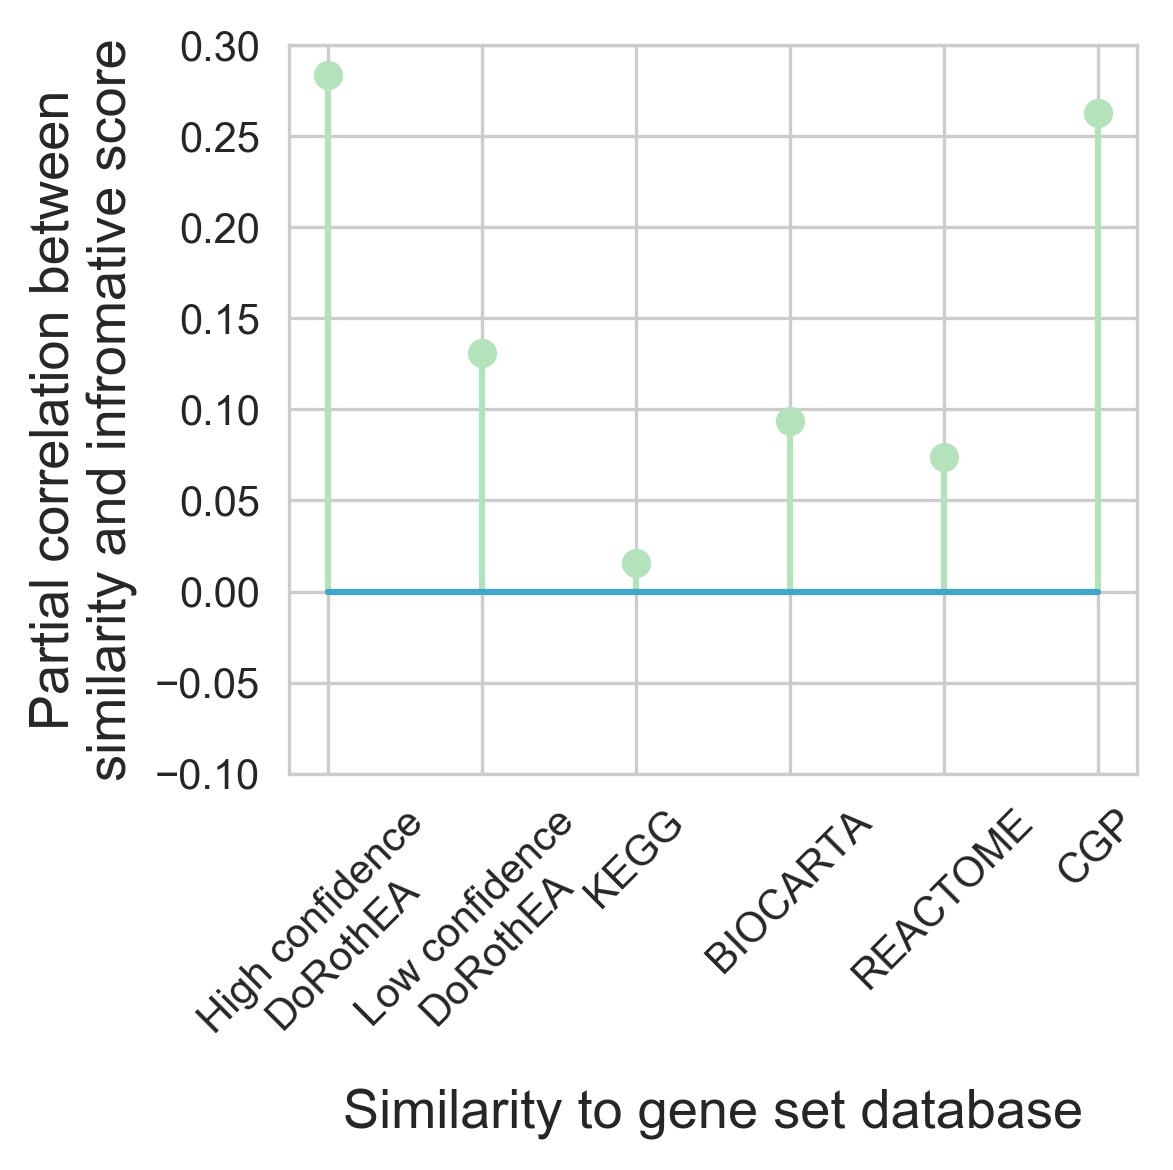

In [6]:
results1 = get_correlations_all_datasets(sim_type='jaccard', rnd_fil='_filtered', bname='progeny', visualise=True)
plt.savefig('../figures/raw/Fig4C.pdf')

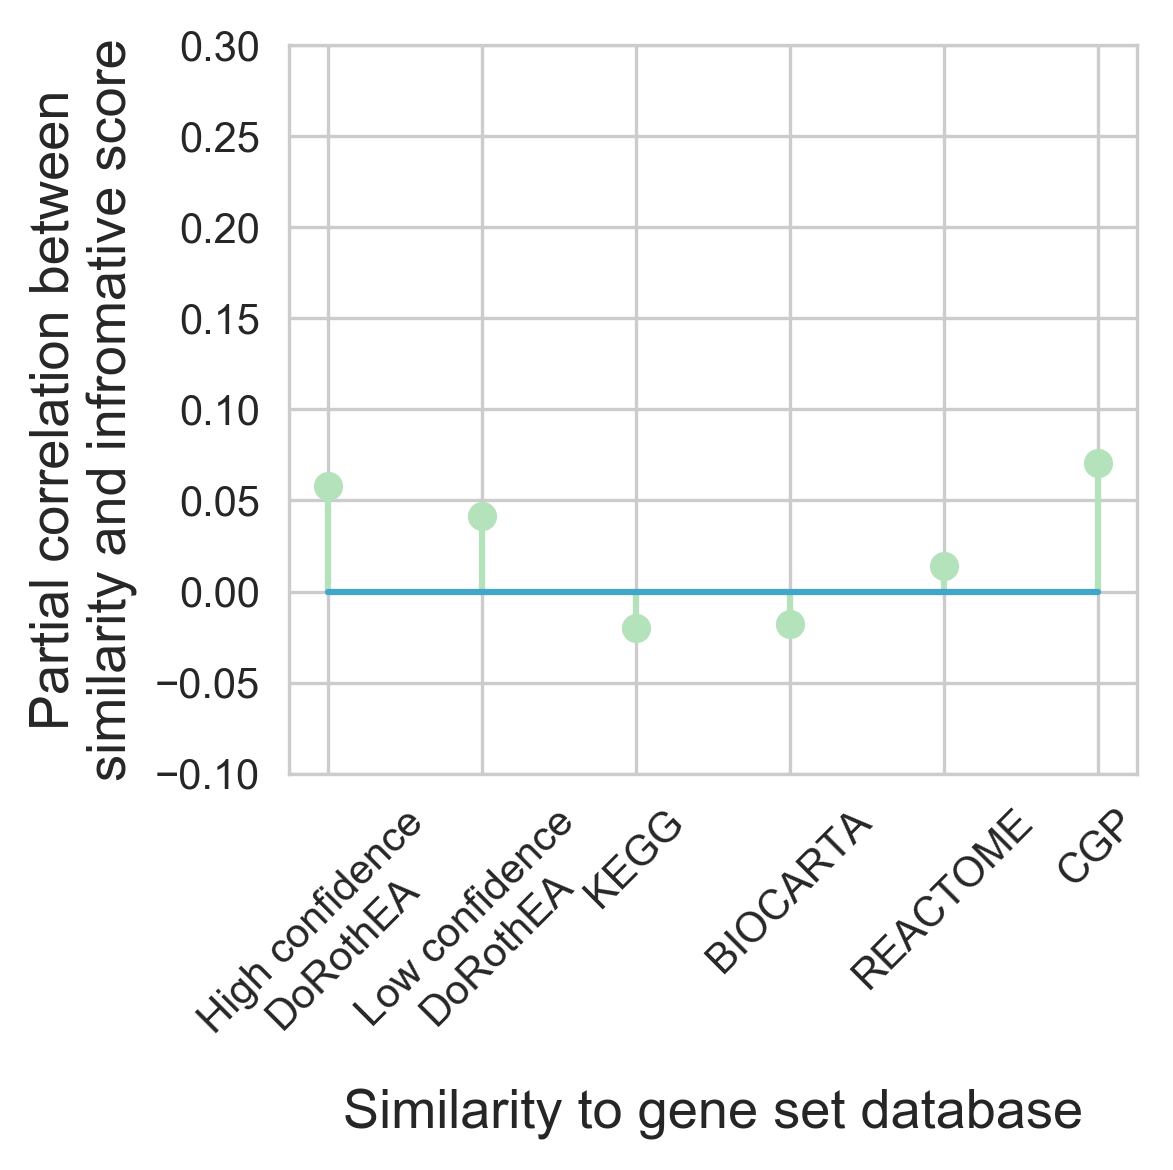

In [7]:
temp = get_correlations_all_datasets(sim_type='jaccard', rnd_fil='_random_dist_0', bname='progeny', visualise=True)
plt.savefig('../figures/raw/Fig4D.pdf')

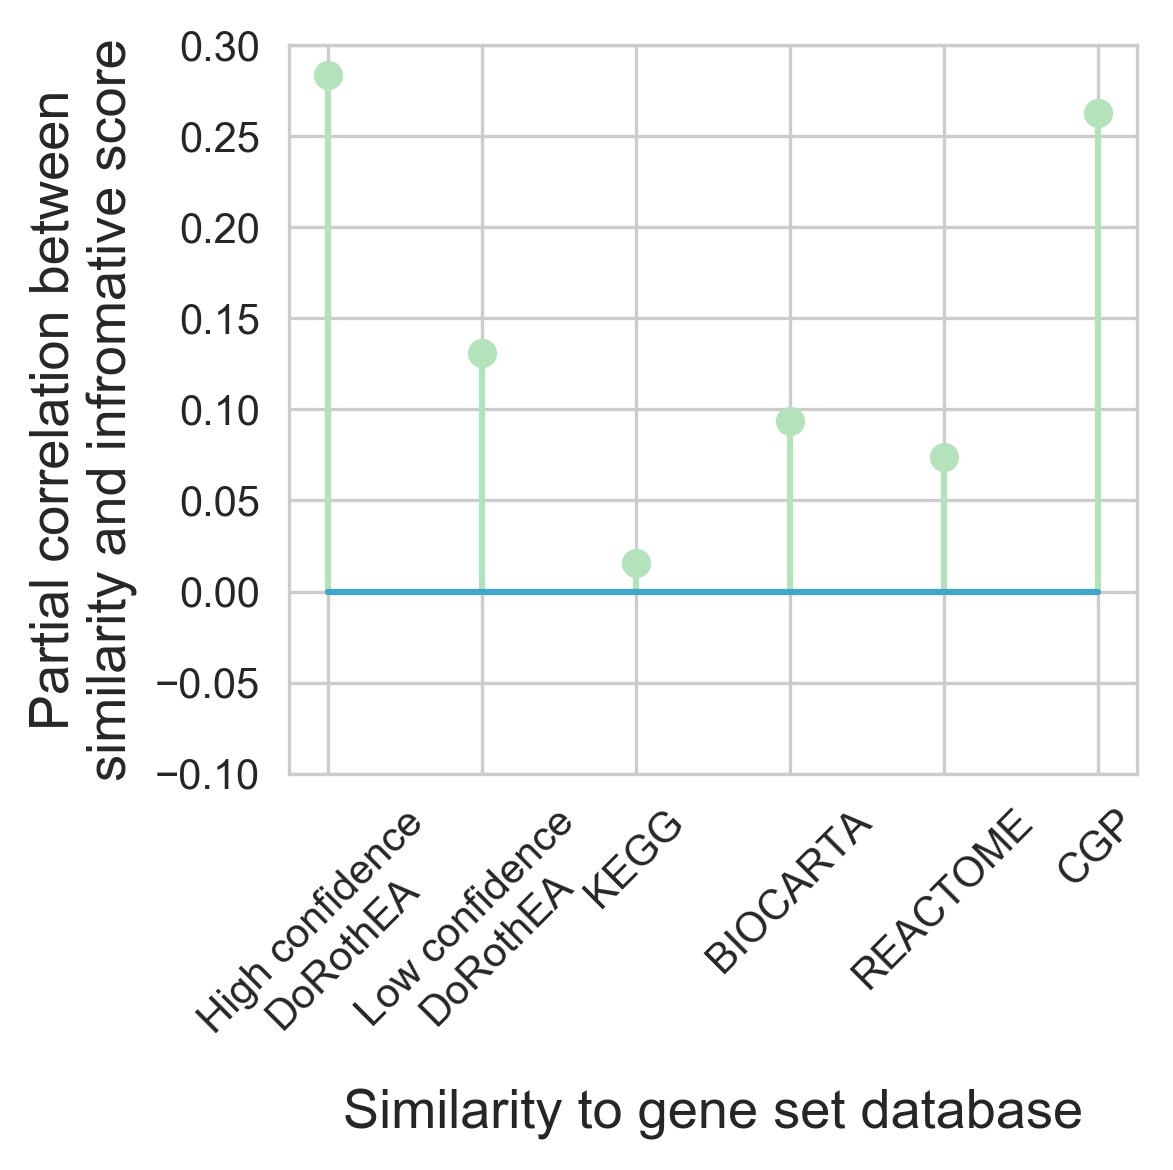

In [8]:
temp = get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_filtered',bname='progeny',sim_type='jaccard',
                                    visualise=True)
plt.savefig('../figures/raw/SFig5A.pdf')

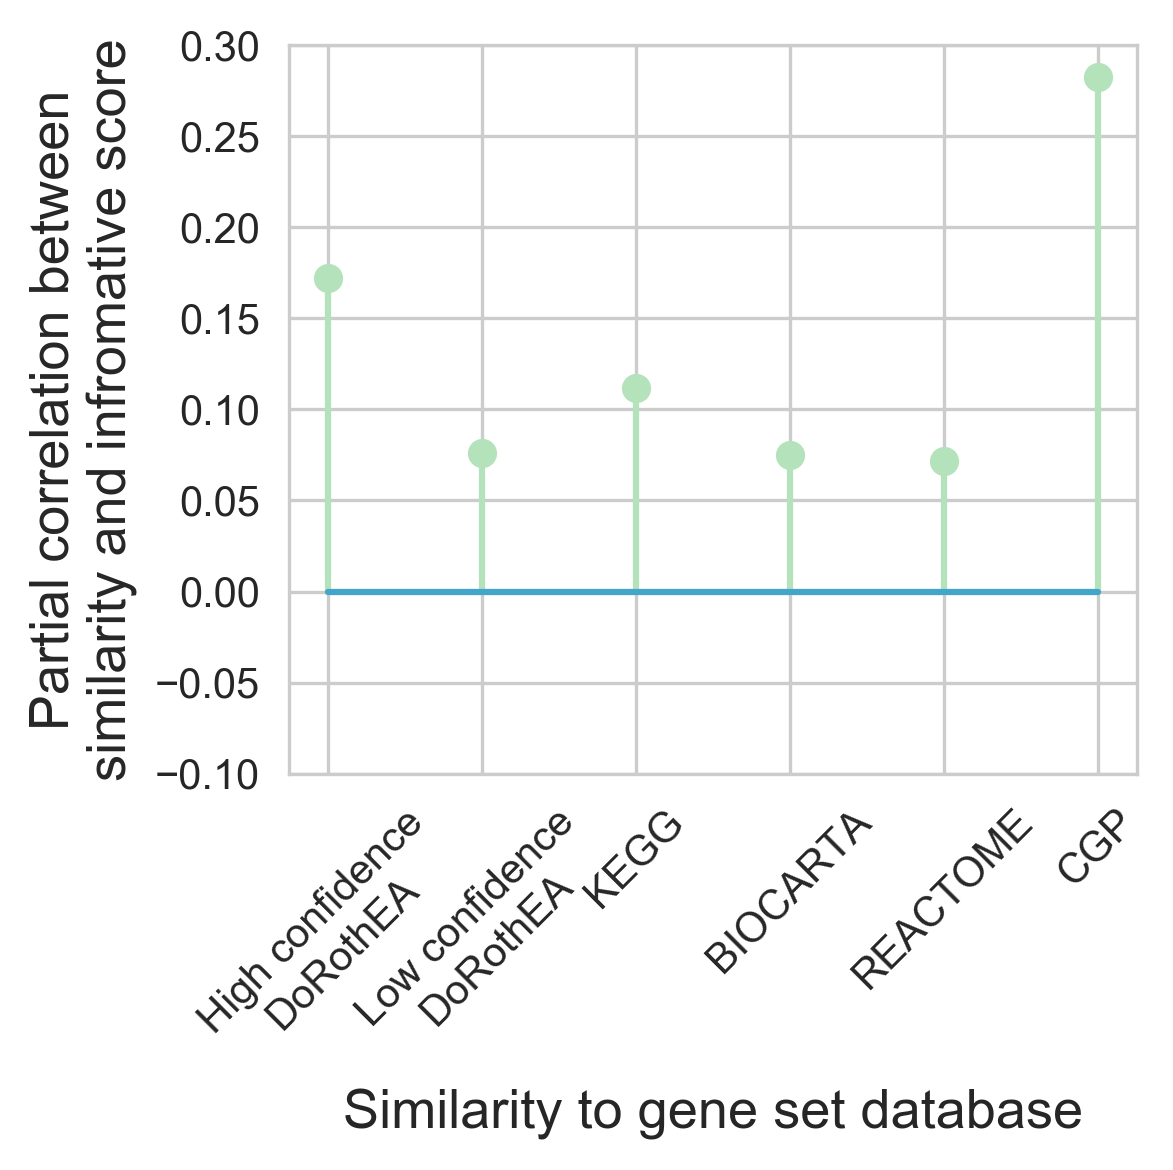

In [9]:
results2 = get_correlations_all_datasets(abs_type= '',rnd_fil='_filtered',bname='progeny',sim_type='jaccard',
                                      visualise=True)
plt.savefig('../figures/raw/SFig5B.pdf')


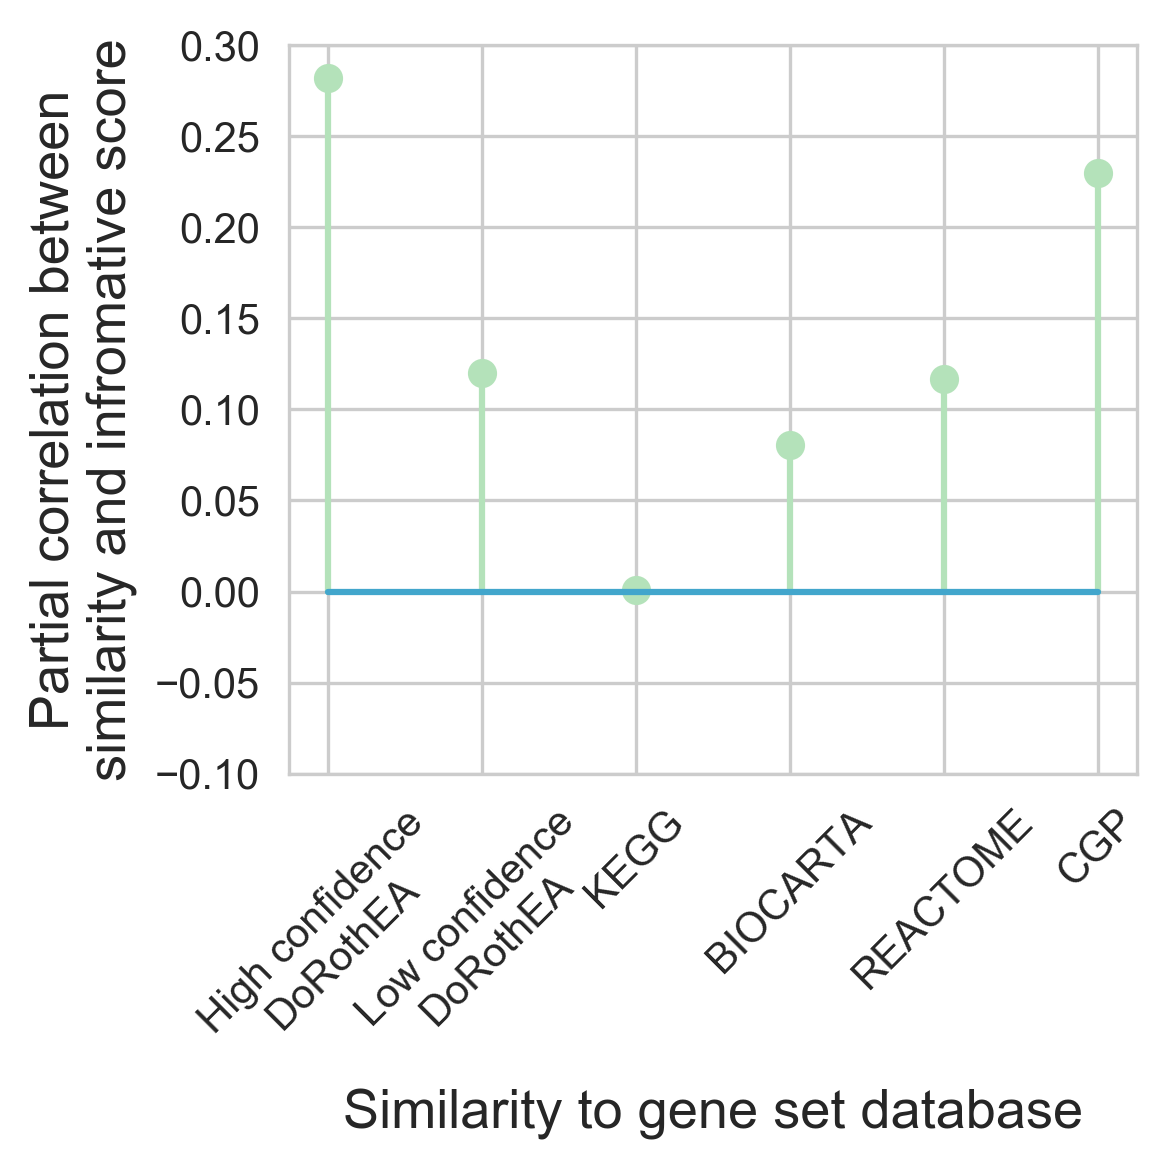

In [10]:
results3 = get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_filtered',bname='progeny',sim_type='overlap',
                                        visualise=True)
plt.savefig('../figures/raw/SFig5C.pdf')

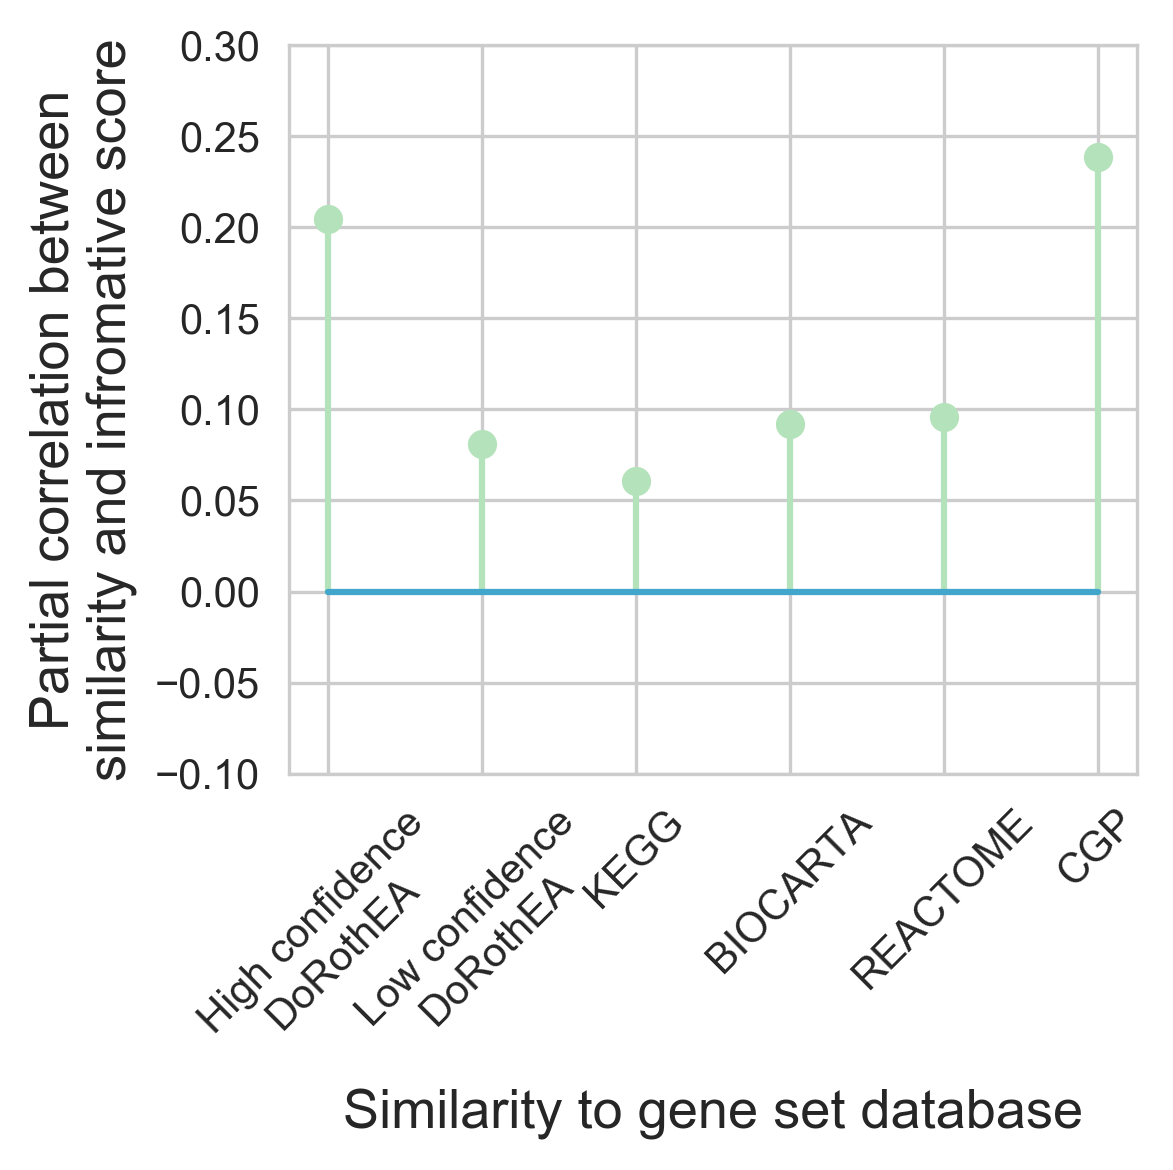

In [11]:
results4 = get_correlations_all_datasets(abs_type= '',rnd_fil='_filtered',bname='progeny',sim_type='overlap',
                                        visualise=True)
plt.savefig('../figures/raw/SFig5D.pdf')

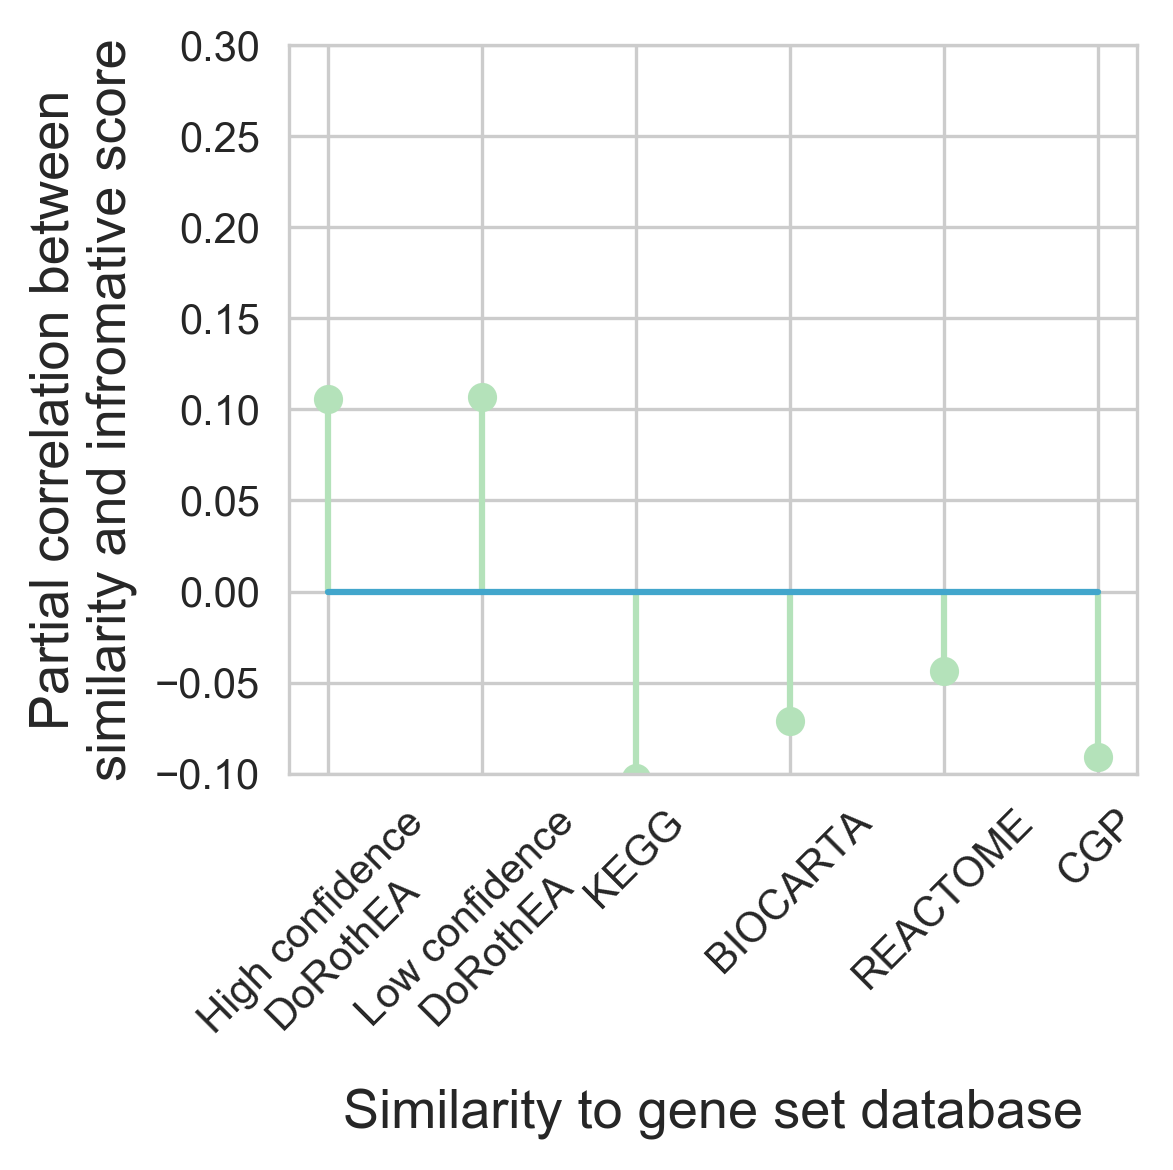

In [12]:
results5 = get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_filtered',bname='gdsc',sim_type='jaccard',
                                        visualise=True)
plt.savefig('../figures/raw/SFig5E.pdf')

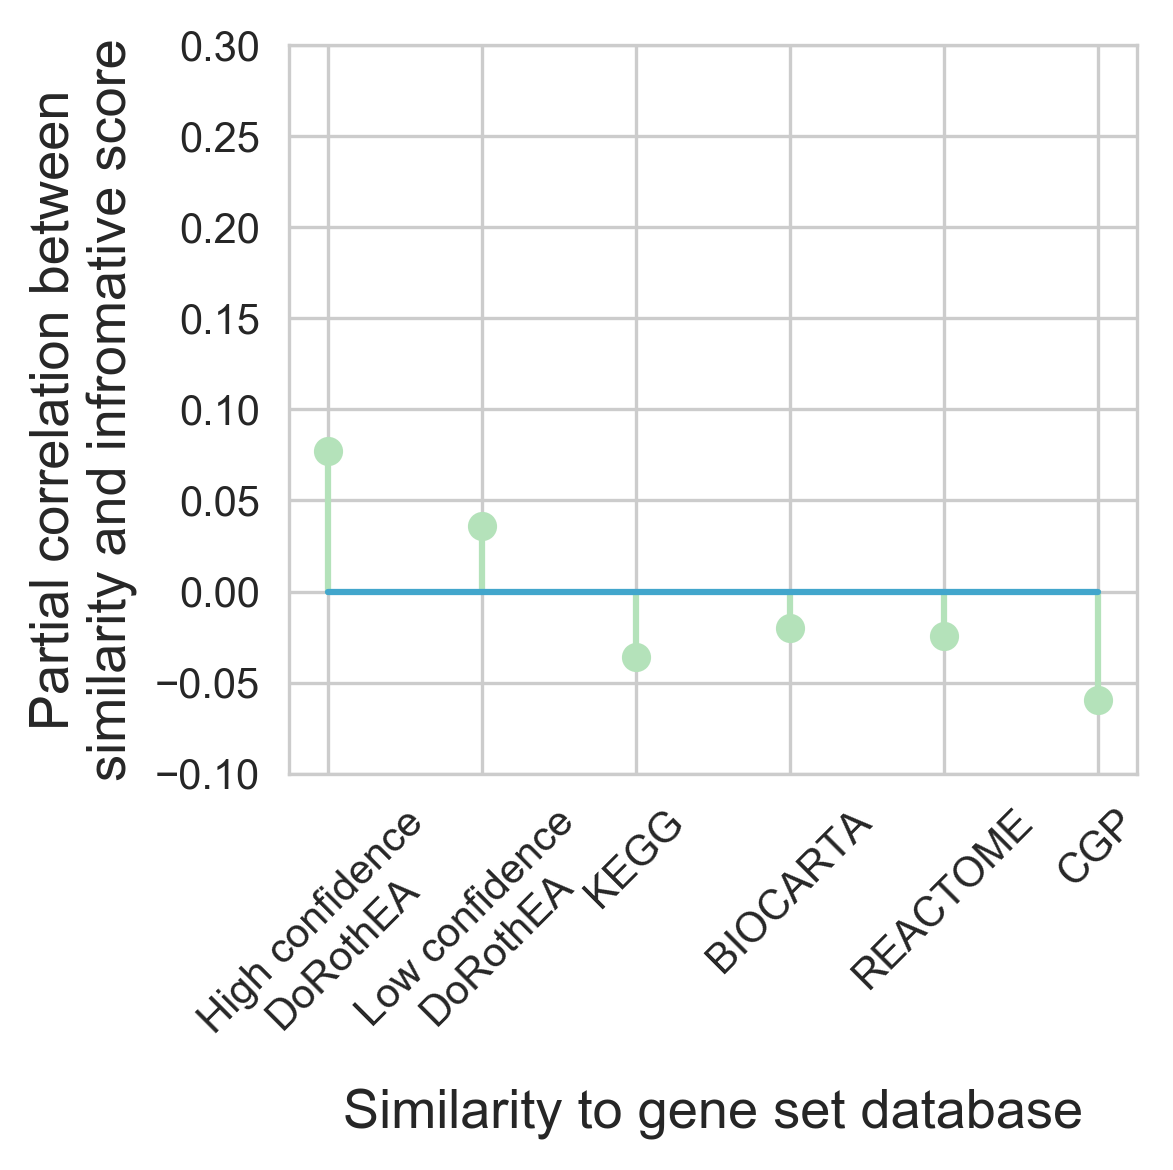

In [13]:
results6 = get_correlations_all_datasets(abs_type= '',rnd_fil='_filtered',bname='gdsc',sim_type='jaccard',
                                        visualise=True)
plt.savefig('../figures/raw/SFig5F.pdf')

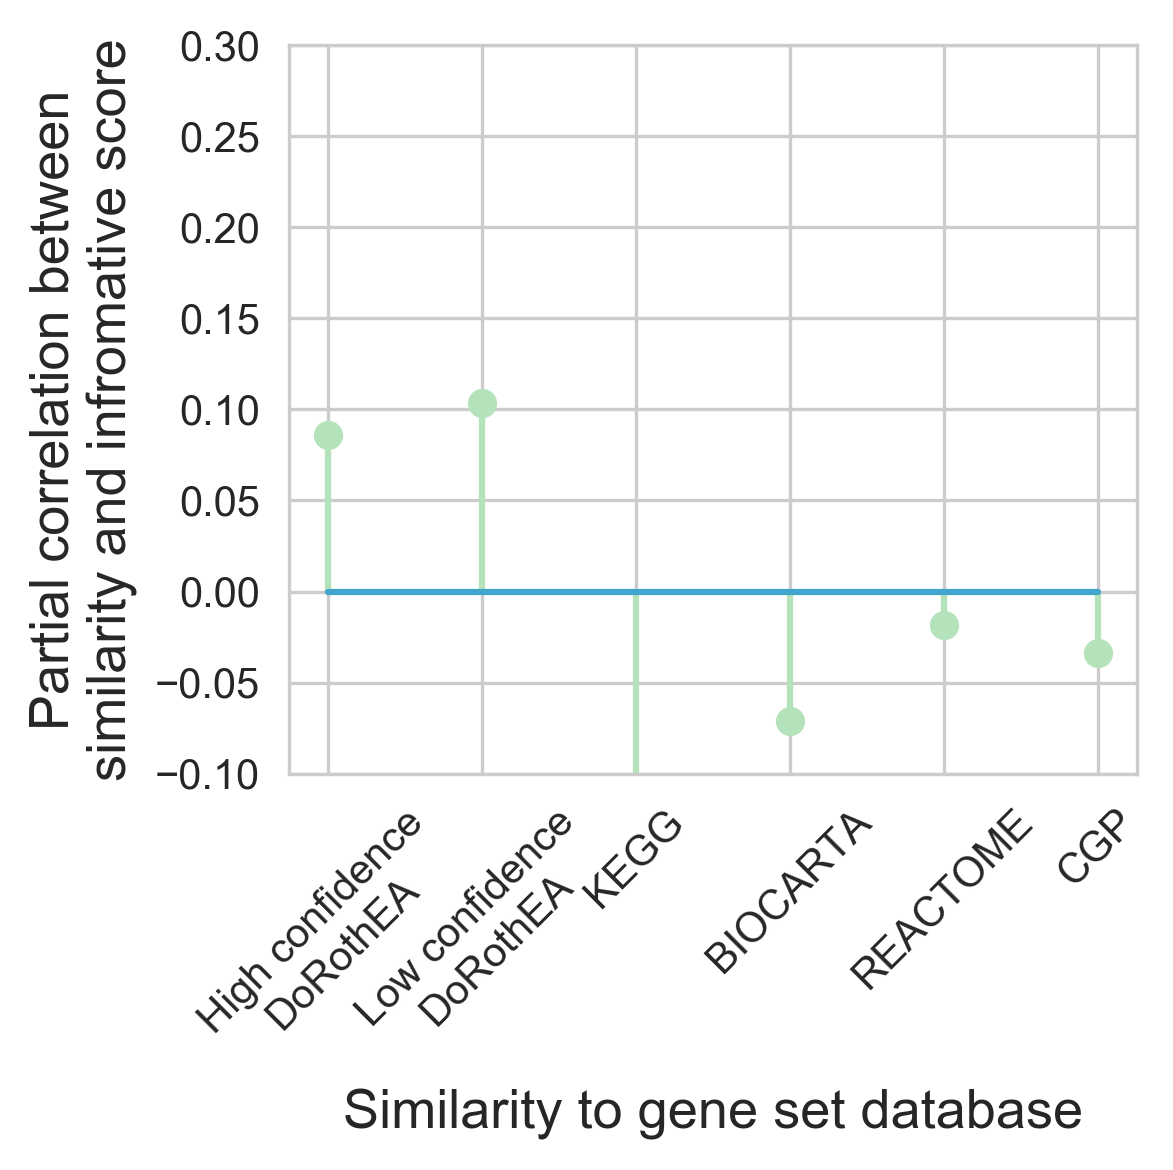

In [14]:
results7 = get_correlations_all_datasets(abs_type= '_abs',rnd_fil='_filtered',bname='gdsc',sim_type='overlap',
                                        visualise=True)
plt.savefig('../figures/raw/SFig5G.pdf')

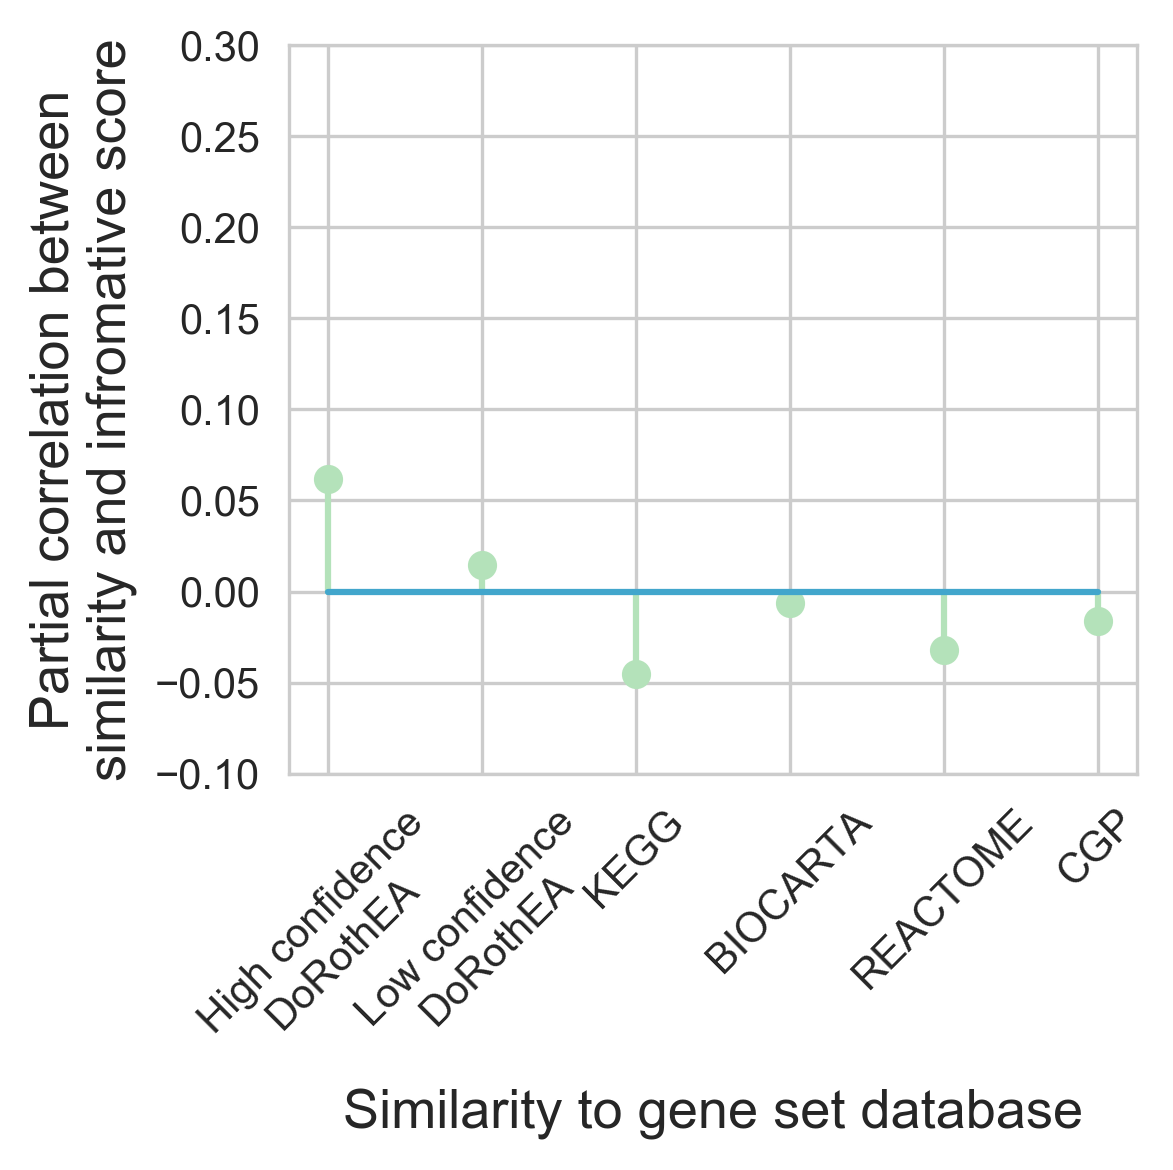

In [15]:
results8 = get_correlations_all_datasets(abs_type= '',rnd_fil='_filtered',bname='gdsc',sim_type='overlap',
                                      visualise=True)
plt.savefig('../figures/raw/SFig5H.pdf')

In [16]:
results = pd.concat([results1, results2, results3, results4,
                    results5, results6, results7, results8])
results.index = range(len(results.index))

In [17]:
results = results[['Benchmark', 'Abs', 'Sim', 'Database', 'r_spearman', 'p_spearman', 'r_part', 'p_part']]

In [18]:
results['Database'] = results['Database'].apply(lambda x: x.replace('\n', ' '))

In [33]:
results.to_csv('../results/benchmark/informative_similarity_stats.csv', index=False)

In [11]:
results = pd.read_csv('../results/benchmark/informative_similarity_stats.csv', sep=',', header=0, index_col=0)

In [17]:
results.loc[results.index[results['Abs'].isna()],'Abs'] = ''

In [29]:
results['Name'] = results['Benchmark'] + results['Abs'] + results['Sim']
results['Value'] = results.apply(lambda x: (x['r_spearman'],
                                           x['p_spearman'],
                                           x['r_part'],
                                           x['p_part']), axis=1)

In [32]:
results = pd.pivot(results, index='Name', columns='Database', values=['Value'])

In [35]:
results.sort_index(ascending=False).to_csv('../results/benchmark/informative_similarity_stats_reshaped.csv')